<a target="_blank" href="https://colab.research.google.com/github/vnghia/5ma-hddl/blob/main/objectness.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>


In [1]:
!pip install -q git+https://github.com/facebookresearch/detectron2@95a87b8dd359014d1ff81fe14f539dd279bcbe4b

In [2]:
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()
%matplotlib inline
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.structures import BoxMode
from detectron2.modeling.proposal_generator.rpn import StandardRPNHead

In [3]:
import numpy as np
import os, json, cv2, random, functools
import matplotlib.pyplot as plt

In [4]:
import torch
import torchvision

In [5]:
objectness = []


def forward_with_objectness(self, features):
    objectness.clear()
    pred_objectness_logits = []
    pred_anchor_deltas = []
    for x in features:
        t = self.conv(x)
        pred_objectness_logits.append(self.objectness_logits(t))
        pred_anchor_deltas.append(self.anchor_deltas(t))
        o = pred_objectness_logits[-1].sigmoid() * 255
        o = o.cpu().detach().numpy()[0, 1]
        objectness.append(o)
    return pred_objectness_logits, pred_anchor_deltas


In [6]:
StandardRPNHead.forward = forward_with_objectness


In [7]:
cfg = model_zoo.get_config("COCO-Detection/rpn_R_50_FPN_1x.yaml", True)

In [8]:
predictor = DefaultPredictor(cfg)

[01/15 11:15:35 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from https://dl.fbaipublicfiles.com/detectron2/COCO-Detection/rpn_R_50_FPN_1x/137258492/model_final_02ce48.pkl ...


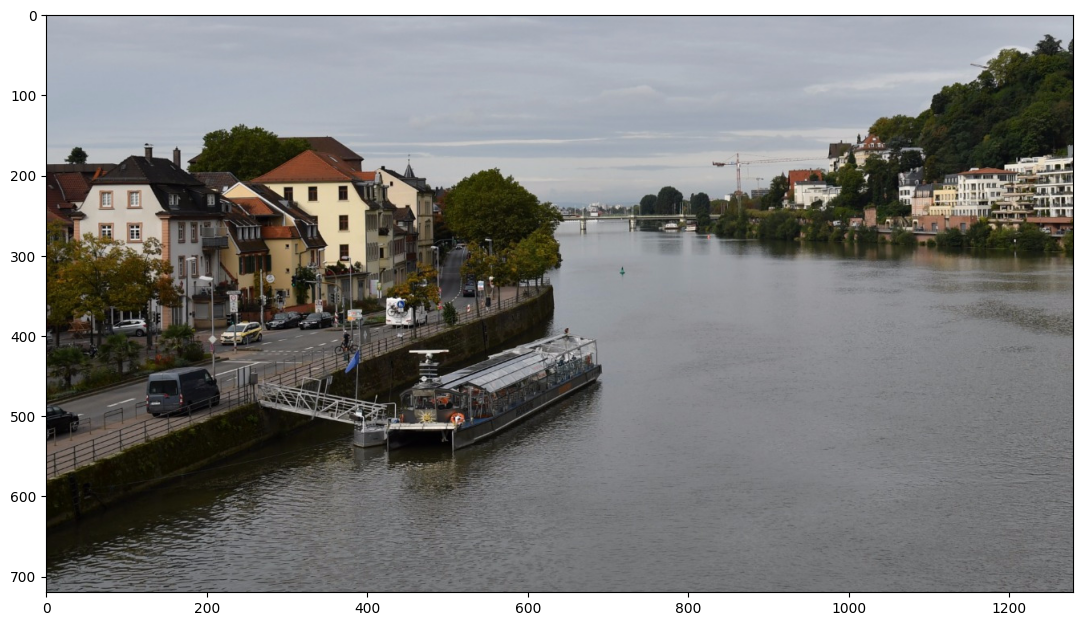

In [9]:
im = cv2.imread("./input.jpg")
plt.figure(figsize=(15, 7.5))
plt.imshow(im[..., ::-1])


In [10]:
outputs = predictor(im[..., ::-1])

/home/xana/code/.pyvenv/efdet/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


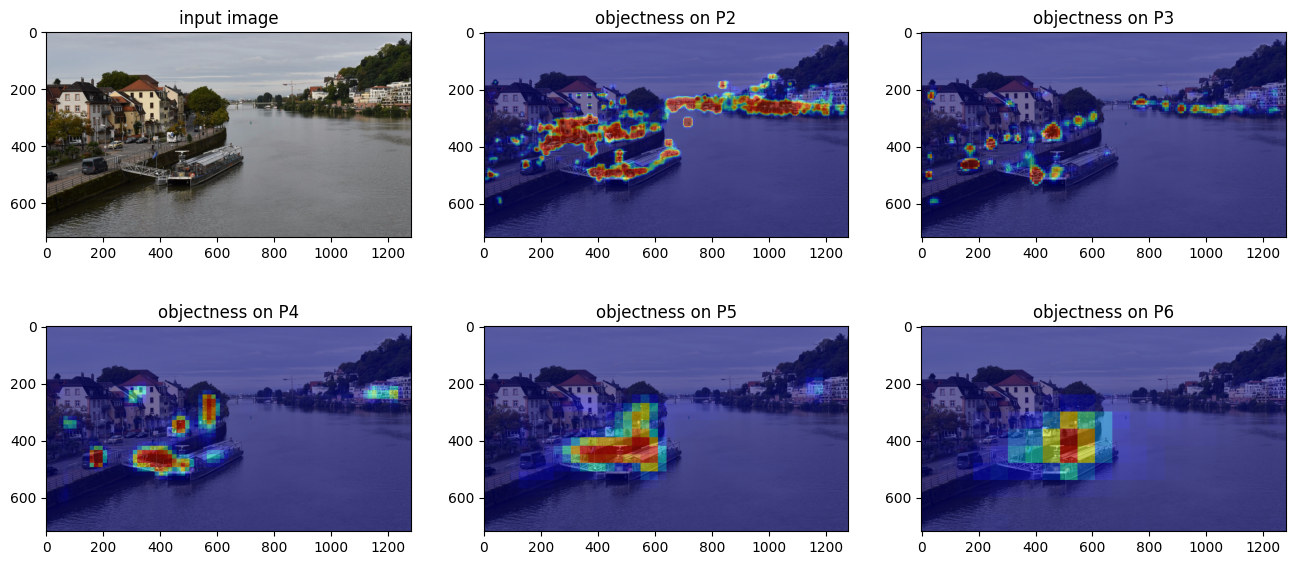

In [11]:
import matplotlib.pyplot as plt
import cv2
from pathlib import Path

imgs = []

h_out, w_out, _ = im.shape

output = Path("objectness")
output.mkdir(parents=True, exist_ok=True)

imgs.append(im)
for i in range(5):  # five levels
    heatmap = np.asarray(
        cv2.resize(
            objectness[i], (w_out, h_out), fx=0, fy=0, interpolation=cv2.INTER_NEAREST
        ),
        dtype=np.uint8,
    )
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    imgs.append(imgs[0] // 2 + heatmap // 2)  # blending
fig = plt.figure(figsize=(16, 7))
for i, img in enumerate(imgs):
    fig.add_subplot(2, 3, i + 1)
    if i > 0:
        title = f"P{i + 1}"
        plt.imshow(img[0:-1, :, ::-1])  # ::-1 removes the edge
        plt.title("objectness on " + title)
        cv2.imwrite(str((output / title).with_suffix(".png")), img)
    else:
        plt.imshow(img[:, :, ::-1])
        plt.title("input image")
        cv2.imwrite(str((output / "input").with_suffix(".png")), img)
plt.show()
